In [16]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import os
import matplotlib.dates as mdates

colors = ['r','r','g','g','b','b']
lines = ['--','-','--','-','--','-']
Zones = ['Low','Mid','High']
Irrigs = ['STD','VRI']

## Get Layout file

In [17]:
Layout = pd.read_excel('K:\CPDiary\Data\BaxtersMVI\TrialLayout.xlsx',index_col='Plot')

## Get the Neutron probe and TDR data

In [18]:
NPFiles = []
TDRFiles = []
mydir = 'K:\CPDiary\Data\BaxtersMVI\Soil moisture data'
for file in os.listdir(mydir):
    if file.endswith('.NP1'):
        NPFiles.append(os.path.join(mydir, file))
    if file.endswith('.NP2'):
        NPFiles.append(os.path.join(mydir, file))
    if file.endswith('.TDR'):
        TDRFiles.append(os.path.join(mydir, file))

## Get all set up with indexing for experiment

In [19]:
#Set up blank dataframe to take data
ColumnLables = ['Plot','Date','D7','D6','D5','D4','D3','D2','D1']
TabIndex = pd.MultiIndex.from_arrays([[],[]],names=['Plot','Date'])
SoilWaterData = pd.DataFrame(columns=ColumnLables[2:],index = TabIndex)
#Read each file
for ObsTable in NPFiles:
    #Read in file and find which lines have legit data
    HeaderRowsToSkip = 29
    DataTab = pd.read_csv(ObsTable,skiprows = range(HeaderRowsToSkip),header=None,delim_whitespace=True)
    DataTab.dropna(inplace=True)
    DataTab.drop([0,1,3,5],axis=1,inplace=True)
    DataTab.columns = ColumnLables
    DataTab.iloc[:,1] = pd.to_datetime(DataTab.iloc[:,1],format='%m/%d/%y')
    SoilWaterData = SoilWaterData.append(DataTab,sort=True)
SoilWaterData.loc[:,'Plot'] = np.int64(SoilWaterData.loc[:,'Plot'] )
SoilWaterData = SoilWaterData.where(SoilWaterData.loc[:,'Plot']<25).dropna()
SoilWaterData.loc[:,'Zone'] = [Layout.loc[int(x),'Zone'] for x in SoilWaterData.Plot]
SoilWaterData.loc[:,'Irrig'] = [Layout.loc[int(x),'Irrig'] for x in SoilWaterData.Plot]
SoilWaterData.loc[:,'Rep'] = [Layout.loc[int(x),'Rep'] for x in SoilWaterData.Plot]
SoilWaterData.set_index(['Plot','Date'],inplace=True,drop=False)
SoilWaterData.sort_index(inplace=True)

#Add in the TDR Data
SoilWaterData.loc[:,'D0'] = np.nan
for TDRTable in TDRFiles:
    TDRData = pd.read_csv(TDRTable,header=None).iloc[:,[2,11,3]]
    TDRData.columns = ['Plot','Date','D0']
    TDRData = TDRData.drop_duplicates(subset=['Plot','Date'])
    TDRData.loc[:,'Date'] = pd.to_datetime(TDRData.loc[:,'Date'], format = '%d%b%Y')
    TDRData.set_index(['Plot','Date'],inplace=True)
    SoilWaterData.update(TDRData)
    
ObsDates = list(SoilWaterData.index.levels[1])

In [20]:
for v in SoilWaterData.index:
    for d in ['D0','D1','D2','D3','D4','D5','D6','D7']:
        if np.isnan(SoilWaterData.loc[v,d]):
            print(d + " " + str(v[0]) + " "+ str(v[1]))

D0 19 2017-11-01 00:00:00


In [21]:
# D0 Data missing for plot 19 on the 1st of November

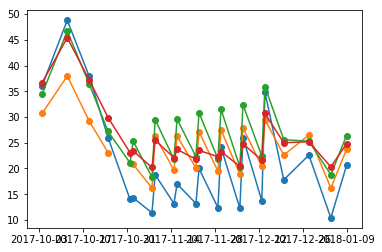

In [22]:
highVRID0 = SoilWaterData.loc[(SoilWaterData.loc[:,'Zone']=='High') & (SoilWaterData.loc[:,'Irrig']=='VRI'),'D0']
plots = highVRID0.index.get_level_values(0).drop_duplicates()
for plot in plots:
    plt.plot(highVRID0.loc[plot],'-o')

19 would be a reasionable estimate for this missing given the other replicates in this treatment

In [23]:
SoilWaterData.loc[(19,'2017-11-01'),'D0'] = 19

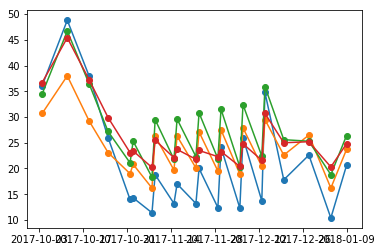

In [24]:
highVRID0 = SoilWaterData.loc[(SoilWaterData.loc[:,'Zone']=='High') & (SoilWaterData.loc[:,'Irrig']=='VRI'),'D0']
plots = highVRID0.index.get_level_values(0).drop_duplicates()
for plot in plots:
    plt.plot(highVRID0.loc[plot],'-o')

## Determine drained upper limit

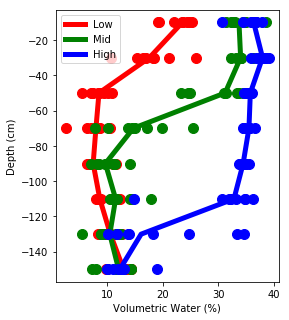

In [25]:
DUL = SoilWaterData.loc[SoilWaterData.Date=='2017-10-04',:].copy()
DUL.index = DUL.index.droplevel(1)
DULGraph, ax = plt.subplots(figsize = (4,5))
pos = 0
cols = ['r','g','b']
for ZoneID in ['Low','Mid','High']:
    ZoneFC = DUL.loc[DUL.Zone==ZoneID,['D0','D1','D2','D3','D4','D5','D6','D7']]
    Mean = ZoneFC.median()
    plt.plot(Mean,[-10,-30,-50,-70,-90,-110,-130,-150],lw=5,color=cols[pos],label = ZoneID)
    for plot in ZoneFC.index:
        plt.plot(ZoneFC.loc[plot].values,[-10,-30,-50,-70,-90,-110,-130,-150],'o', color = cols[pos],ms=10)
    pos += 1
plt.ylabel('Depth (cm)')
plt.xlabel('Volumetric Water (%)')
plt.legend(loc=2)

## Determine other soil parameters for all plots and depths

In [26]:
#Calculate Saturated water content for top soil (soil_layer = 1) and sub soils (all other layers)
#DUL must be input as mm3/mm3
def Est_SAT_from_DUL(DUL, soil_layer):
    if soil_layer <= 2:
        break_point = 30
        slope1 = 0.35
        Intercept1 = 30
        slope2 = 0.7
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)
    else: 
        break_point = 25
        slope1 = 0.07
        Intercept1 = 30
        slope2 = 0.8
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)

    if DUL <= break_point:
        Est_SAT = Intercept1 + DUL * slope1
    else:
        Est_SAT = Intercept2 + DUL * slope2
    return Est_SAT

#Calculate Saturated water content for top soil (soil_layer = 1) and sub soils (all other layers)
def Est_LL_from_DUL(DUL, soil_layer):
    DUL_vol = DUL
    if soil_layer <= 2:
        break_point = 25
        slope1 = 0.2522
        Intercept1 = 0 
        slope2 = 0.835
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)
    else: 
        break_point = 25
        slope1 = 0.5
        Intercept1 = 0
        slope2 = 0.8
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)

    if DUL_vol <= break_point:
        Estimate_LL_vol = Intercept1 + DUL_vol * slope1
    else:
        Estimate_LL_vol = Intercept2 + DUL_vol * slope2
    return Estimate_LL_vol

# Set up dataFrames for other parameters
LL = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
LL.loc[:,['D1','D2','D3','D4','D5','D6','D7']]=0
SAT = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
SAT.loc[:,['D1','D2','D3','D4','D5','D6','D7']]=0
TP = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
TP.loc[:,['D1','D2','D3','D4','D5','D6','D7']]=0
RT = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
RT.loc[:,['D1','D2','D3','D4','D5','D6','D7']]=0

#Calculate parameter values for each depth
for plot in DUL.index:
    li = 0
    for l in ['D0','D1','D2','D3','D4','D5','D6','D7']:
        LL.loc[plot,l] = Est_LL_from_DUL(DUL.loc[plot,l],li)
        SAT.loc[plot,l] = Est_SAT_from_DUL(DUL.loc[plot,l],li)
        TP.loc[plot,l] = LL.loc[plot,l] + (DUL.loc[plot,l]-LL.loc[plot,l]) * 0.5
        RT.loc[plot,l] = LL.loc[plot,l] + (DUL.loc[plot,l]-LL.loc[plot,l]) * 0.9
        li +=1

### Calclculate soil profile parameters for each treatment

In [27]:
TreatIndex = pd.MultiIndex.from_product([['Low','Mid','High'],['STD','VRI']])
ProfileParams = pd.DataFrame(index = ['SAT','DUL','RT','TP','LL'],columns=TreatIndex)
Params80 = pd.DataFrame(index = ['SAT','DUL','RT','TP','LL'],columns=TreatIndex)
#All params multiplied by 2 to convert from % to mm
for treat in ProfileParams.columns:
    Filt = (SAT.Zone == treat[0]) & (SAT.Irrig == treat[1])
    ProfileParams.loc['SAT',treat] = SAT.loc[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.loc['SAT',treat] = SAT.loc[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.loc['DUL',treat] = DUL.loc[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.loc['DUL',treat] = DUL.loc[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.loc['RT',treat] = RT.loc[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.loc['RT',treat] = RT.loc[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.loc['TP',treat] = TP.loc[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.loc['TP',treat] = TP.loc[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.loc['LL',treat] = LL.loc[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.loc['LL',treat] = LL.loc[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    Params80.loc['IrrigCapacity',treat] = Params80.loc['RT',treat] - Params80.loc['TP',treat]

C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

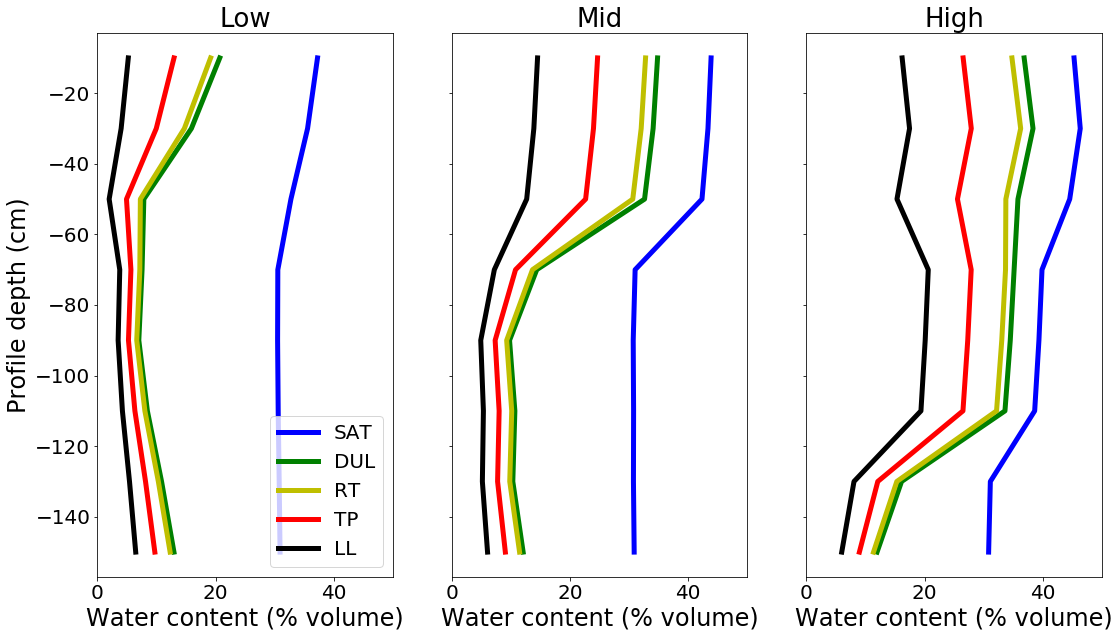

In [28]:
ProfileGraphs = plt.figure(figsize=(18,10))
axes = []
PlotPos = 1
for ZoneID in ['Low','Mid','High']:
    axes.append(ProfileGraphs.add_subplot(1,3,PlotPos))
    pos = 0
    cols = ['b','g','y','r','k']
    labs = ['SAT','DUL','RT','TP','LL']
    yloc = [-130,-140,-150]
    for Data in [SAT,DUL,RT,TP,LL]:
        Filter = (Data.Zone == ZoneID) & (Data.Irrig == 'STD')
        ParamWC = Data.loc[Filter,['D0','D1','D2','D3','D4','D5','D6','D7']]
        TreatMean = ParamWC.median()
        plt.plot(TreatMean,[-10,-30,-50,-70,-90,-110,-130,-150],'-',color=cols[pos],lw=5,label=labs[pos])
        plt.title(ZoneID,fontsize=26)
        pos +=1
    if PlotPos in [2,3]:
        axes[PlotPos-1].tick_params(labelleft='off') 
    if PlotPos ==1:
        plt.ylabel('Profile depth (cm)',fontsize=24)
        plt.legend(loc=4,fontsize=20)
    plt.xlabel('Water content (% volume)',fontsize=24)
    plt.tick_params(labelsize=20)
    plt.xlim(0,50)
    PlotPos += 1
    
plt.tight_layout 

C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


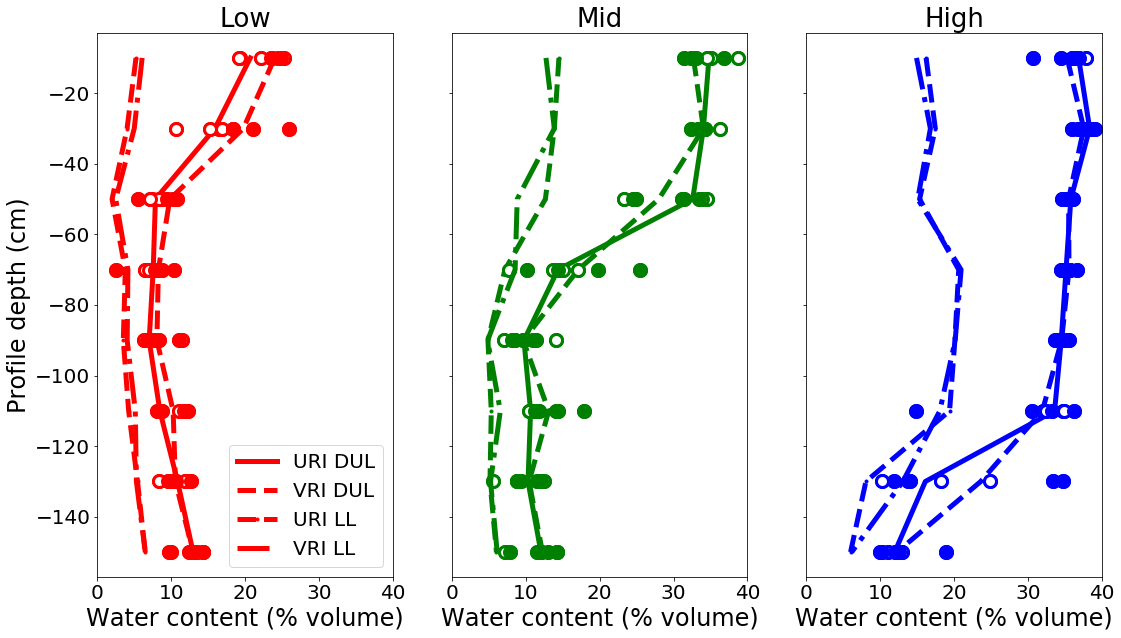

In [29]:
ProfileGraphs = plt.figure(figsize=(18,10))
axes = []
PlotPos = 1
Zcols = ['r','g','b']
for ZoneID in ['Low','Mid','High']:
    axes.append(ProfileGraphs.add_subplot(1,3,PlotPos))
    cols = ['cyan','k']
    labs = ['DUL','DUL','LL','LL']
    lines = ['-','--','--.','-.']
    yloc = [-130,-140,-150]
    lpos = 0
    Ilabs = ['URI','VRI']
    for Data in [DUL,LL]:
        pos = 0
        for I in Irrigs:
            Filter = (Data.Zone == ZoneID) & (Data.Irrig == I)
            ParamWC = Data.loc[Filter,['D0','D1','D2','D3','D4','D5','D6','D7']]
            TreatMean = ParamWC.median()
            plt.plot(TreatMean,[-10,-30,-50,-70,-90,-110,-130,-150],lines[lpos],color=Zcols[PlotPos-1],lw=5,label=Ilabs[pos] + ' ' + labs[lpos])
            plt.title(ZoneID,fontsize=26)
            ZoneFC = DUL.loc[DUL.Zone==ZoneID,['D0','D1','D2','D3','D4','D5','D6','D7']]
            for plot in ZoneFC.index:
                if Data.loc[plot,'Irrig'] == I:
                    if I == 'STD':
                        fillC = 'W'
                    else:
                        fillC = Zcols[PlotPos-1]
                    plt.plot(ZoneFC.loc[plot].values,[-10,-30,-50,-70,-90,-110,-130,-150],'o', mec = Zcols[PlotPos-1],mfc = fillC,ms=12,mew=3)
            pos += 1
            lpos+=1
    if PlotPos in [2,3]:
        axes[PlotPos-1].tick_params(labelleft='off') 
    if PlotPos ==1:
        plt.ylabel('Profile depth (cm)',fontsize=24)
        plt.legend(loc=4,fontsize=20)
    plt.xlabel('Water content (% volume)',fontsize=24)
    plt.tick_params(labelsize=20)
    plt.xlim(0,40)
    PlotPos += 1
    
plt.tight_layout 

ProfileGraphs.savefig('K:\\CPDiary\\Data\\BaxtersMVI\\draft papers\\Submission versions\\resub\RevisedBaxtersIrrigPaper\\Figure2.jpg',dpi=400)

In [30]:
Params = ['SAT','DUL','RT','TP','LL']
for dep in SoilWaterData.sort_index(axis=1).columns[:8]:
    for Param in Params:
        ParamAndDep = Param+'_'+dep
        SoilWaterData.loc[:,ParamAndDep] = np.nan
        CurrentParam = globals()[Param]
        for plot in range(1,25):
            SoilWaterData.loc[plot,ParamAndDep] = CurrentParam.loc[plot,dep]

### Get data into a excel useful format and export

In [31]:
SoilWaterData.sort_index(axis=1,inplace=True)
SoilWaterData.set_index(['Zone','Irrig','Rep','Date','Plot'],inplace=True)
SoilWaterData.sort_index(inplace=True)
SoilWaterData.loc[:,'ProfileWater'] = [np.sum(SoilWaterData.loc[x,:][['D0','D1','D2','D3','D4','D5','D6','D7']])*2 for x in SoilWaterData.index]
SoilWaterData.loc[:,'RootZoneWater'] = [np.sum(SoilWaterData.loc[x,:][['D0','D1','D2','D3','D4','D5']])*2 for x in SoilWaterData.index]
#SoilWaterData.to_excel('K:\CPDiary\Data\BaxtersMVI\SoilWaterRawData.xlsx',merge_cells=False,sheet_name='RawData')

## Set up the irrigaiton and rainfall data frame

In [32]:
#Set up a data frame and put the irrigation data in manually
ColIndex = pd.MultiIndex.from_product([('Low','Mid','High'),('STD','VRI')])
DateIndex = SoilWaterData.index.get_level_values(3).drop_duplicates()
Irrigations = pd.DataFrame(index=DateIndex,columns=ColIndex)
Irrigations.loc[:,:] = 0
Irrigations.loc['2017-10-25',:] = [0,0,0,0,0,0]
Irrigations.loc['2017-11-01',:] = [12.0,12.0,12.0,12.0,12.0,12.0]
Irrigations.loc['2017-11-08',:] = [56.1,27,56.1,37,56.1,37]
Irrigations.loc['2017-11-15',:] = [36.3,28,36.3,25.8,36.3,25.8]
Irrigations.loc['2017-11-22',:] = [30.6,25.1,30.6,27.1,30.6,28.1]
Irrigations.loc['2017-11-29',:] = [31.5,32,31.5,30,31.5,33]
Irrigations.loc['2017-12-06',:] = [41.8,30.3,41.8,40.3,41.8,43.3]
Irrigations.loc['2017-12-13',:] = [45.9,29,45.9,38,45.9,41]

#Bring in the rainfall data sum it over measurement periods and add into irrigation dataframe
Irrigations.loc[:,('Field','Rain')] = 0
DailyRain = pd.read_pickle('Rainfall.pkl')
PrevMeasureDate = ''
for P in Irrigations.index:
    if P.strftime('%Y-%m-%d') == '2017-10-04':
        PrevMeasureDate = '2017-10-04'
    else:
        YesterdayDate = (P - dt.timedelta(1)).strftime('%Y-%m-%d')
        Irrigations.loc[P.strftime('%Y-%m-%d'),('Field','Rain')] = DailyRain.loc[PrevMeasureDate:YesterdayDate].sum()
        PrevMeasureDate = P.strftime('%Y-%m-%d')

# Calculate Water use from water balance

In [33]:
ColIndex = pd.MultiIndex.from_product([('Low','Mid','High'),('STD','VRI'),(1,2,3,4)],names=['Zone','Irrig','Rep'])
WaterUseNP = pd.DataFrame(index = Irrigations.index,
    columns = ColIndex)
WaterUseNP.loc[:,:]=0
DeltaSWCFrame = WaterUseNP.copy()
IrrigationFrame = WaterUseNP.copy()
RainFallFrame = WaterUseNP.copy()
for plot in WaterUseNP.columns:
    for P in WaterUseNP.index:
        if P.strftime('%Y-%m-%d') == '2017-10-04':
            PrevPSWC = SoilWaterData.loc[(plot)].loc[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = '2017-10-04'
        else:
            #print(P.strftime('%Y-%m-%d'))
            DeltaSWC = PrevPSWC - SoilWaterData.loc[(plot)].loc[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            #print(DeltaSWC)
            DeltaSWCFrame.loc[P.strftime('%Y-%m-%d'),plot] = DeltaSWC
            Irrigation = Irrigations.loc[PrevMeasureDate,(plot[0],plot[1])]
            IrrigationFrame.loc[P.strftime('%Y-%m-%d'),plot] = Irrigation
            #print(Irrigation)
            Rainfall = Irrigations.loc[P.strftime('%Y-%m-%d'),('Field','Rain')]
            RainFallFrame.loc[P.strftime('%Y-%m-%d'),plot] = Rainfall
            #print(Rainfall)
            WU = DeltaSWC + Irrigation + Rainfall 
            #print(WU)
            WaterUseNP.loc[P.strftime('%Y-%m-%d'),plot] = WU
            PrevPSWC = SoilWaterData.loc[(plot)].loc[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = P.strftime('%Y-%m-%d')

#Days when irrigation needs to be considered in NP water balance calculations
IrrigationsDaysNP = ['2017-11-02','2017-11-09','2017-11-16','2017-11-23',
                   '2017-11-30','2017-12-07','2017-12-14',]

#Remove days when irrigatin was applied
#WaterUseNP.loc[WaterUseNP.index.isin(IrrigationsDaysNP)] = np.nan
#WaterUseNP.dropna(how='all',inplace=True)

## Bring in the Water use estimations from IRs

In [34]:
#Days when irrigation occured
IrrigationsDaysIR = ['2017-11-01','2017-11-08','2017-11-15','2017-11-22',
                   '2017-11-29','2017-12-06','2017-12-13',]


#Read in the E data calculated from IR sensors
E = pd.read_pickle('Evaporation.pkl')

#Remove errant values
E.loc['2017-11-9':'2017-11-15',('Low','STD',4)] = E.loc['2017-11-9':'2017-11-15',('Low','STD')].loc[:,1:3].mean(axis=1)
E.loc[:,('Low','VRI',4)] = np.nan

#Remove days when irrigatin was applied
#E.loc[E.index.isin(IrrigationsDaysIR),:] = np.nan
#E.dropna(how='all',inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


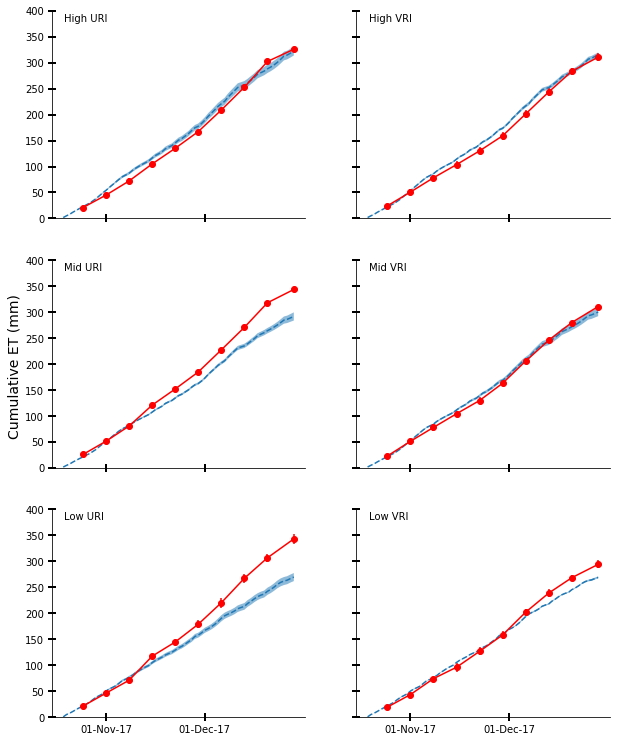

In [35]:
ObsPreIndex = pd.MultiIndex.from_product([['Obs','Pred'],['High','Mid','Low'],['STD','VRI']])
ObsPre = pd.DataFrame(index = E.index,columns = ObsPreIndex)
Fig = plt.figure(figsize=(10,13))
pos = 1
IrrLabs = ['URI', 'VRI','URI', 'VRI','URI', 'VRI']
for z in ['High','Mid','Low']:
    for i in Irrigs:
        ax = Fig.add_subplot(3,2,pos)
        IRMean = E.loc[:'2017-12-28',(z,i)].cumsum().mean(axis=1)
        ObsPre.loc[:,('Pred',z,i)] = IRMean
        IRSD = E.loc[:'2017-12-28',(z,i)].cumsum().std(axis=1)/2
        IRUp = IRMean + IRSD
        IRLow = IRMean - IRSD
        plt.fill_between(IRMean.index,IRUp,IRLow,alpha=0.5,lw=0)
        plt.plot(IRMean,'--')
        NPMean = WaterUseNP.loc['2017-10-20':,(z,i)].cumsum().mean(axis=1)
        ObsPre.loc[:,('Obs',z,i)] = NPMean
        DatesToShow = NPMean.index.isin(['2017-10-25','2017-11-01', 
         '2017-11-08', '2017-11-15', '2017-11-22', '2017-11-29', '2017-12-06',
         '2017-12-13', '2017-12-20', '2017-12-28'])
        NPSD = WaterUseNP.loc['2017-10-20':,(z,i)].cumsum().std(axis=1)/2
        NPUp = NPMean + NPSD
        NPLow = NPMean - NPSD
        plt.errorbar(NPMean.loc[DatesToShow].index,
                     NPMean.loc[DatesToShow],NPSD.loc[DatesToShow],fmt='-o',color='r')
        plt.text(0.05,0.95,z+' ' +IrrLabs[pos-1],transform = ax.transAxes)
        plt.ylim(0,400)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
        plt.xticks(rotation=0)
        if pos in [1,2,3,4]:
            plt.tick_params(axis='x', length = 8, width = 2,direction = 'inout',bottom='on',top='off', labelbottom='off')
        else:
            plt.tick_params(axis='x', length = 8, width = 2,direction = 'inout',bottom='on',top='off', labelbottom='on')
        if pos in [2,4,6]:
            plt.tick_params(axis='y', length = 8, width = 2,direction = 'inout',left='on',right='off',labelleft = 'off', labelright='off')
        else:
            plt.tick_params(axis='y', length = 8, width = 2,direction = 'inout',left='on',right='off',labelleft = 'on', labelright='off')
        if pos == 3:
            plt.ylabel('Cumulative ET (mm) ',fontsize=14)
        pos += 1
Fig.savefig('K:\\CPDiary\\Data\\BaxtersMVI\\draft papers\\Submission versions\\resub\RevisedBaxtersIrrigPaper\\Figure6.jpg',dpi=400)        

In [36]:
['High','Mid','Low']

['High', 'Mid', 'Low']

In [37]:
Irrigs

['STD', 'VRI']

In [38]:
E.loc[:'2017-12-28',('Low','VRI')].cumsum().mean(axis=1)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


2017-10-19      0.821625
2017-10-20      5.290829
2017-10-21      7.947472
2017-10-22     11.517065
2017-10-23     15.158753
2017-10-24     18.542343
2017-10-25     20.779363
2017-10-26     25.469763
2017-10-27     28.888713
2017-10-28     33.932195
2017-10-29     38.493234
2017-10-30     41.711791
2017-10-31     45.143125
2017-11-01     50.373252
2017-11-02     54.335908
2017-11-03     57.060406
2017-11-04     60.280268
2017-11-05     65.504126
2017-11-06     70.742164
2017-11-07     73.015541
2017-11-08     76.904642
2017-11-09     80.421230
2017-11-10     85.525317
2017-11-11     89.511619
2017-11-12     93.740224
2017-11-13     97.199509
2017-11-14    100.300596
2017-11-15    105.619696
2017-11-16    109.908910
2017-11-17    113.146815
                 ...    
2017-11-29    159.766876
2017-11-30    164.348798
2017-12-01    169.247679
2017-12-02    172.507477
2017-12-03    176.501509
2017-12-04    181.631580
2017-12-05    187.853215
2017-12-06    193.943063
2017-12-07    198.926075


C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


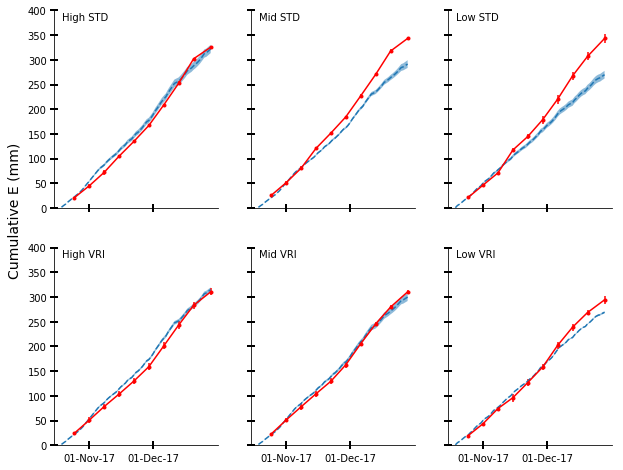

In [39]:
ObsPreIndex = pd.MultiIndex.from_product([['Obs','Pred'],['High','Mid','Low'],['STD','VRI']])
ObsPre = pd.DataFrame(index = E.index,columns = ObsPreIndex)
Fig = plt.figure(figsize=(10,8))
pos = 1
for i in Irrigs:
    for z in ['High','Mid','Low']:
        ax = Fig.add_subplot(2,3,pos)
        IRMean = E.loc[:'2017-12-28',(z,i)].cumsum().mean(axis=1)
        ObsPre.loc[:,('Pred',z,i)] = IRMean
        IRSD = E.loc[:'2017-12-28',(z,i)].cumsum().std(axis=1)/2
        IRUp = IRMean + IRSD
        IRLow = IRMean - IRSD
        plt.fill_between(IRMean.index,IRUp,IRLow,alpha=0.5,lw=0)
        plt.plot(IRMean,'--')
        NPMean = WaterUseNP.loc['2017-10-20':,(z,i)].cumsum().mean(axis=1)
        ObsPre.loc[:,('Obs',z,i)] = NPMean
        DatesToShow = NPMean.index.isin(['2017-10-25','2017-11-01', 
         '2017-11-08', '2017-11-15', '2017-11-22', '2017-11-29', '2017-12-06',
         '2017-12-13', '2017-12-20', '2017-12-28'])
        NPSD = WaterUseNP.loc['2017-10-20':,(z,i)].cumsum().std(axis=1)/2
        NPUp = NPMean + NPSD
        NPLow = NPMean - NPSD
        plt.errorbar(NPMean.loc[DatesToShow].index,
                     NPMean.loc[DatesToShow],NPSD.loc[DatesToShow],fmt='-o',color='r',ms=3)
        plt.text(0.05,0.95,z+' ' +i,transform = ax.transAxes)
        plt.ylim(0,400)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
        plt.xticks(rotation=0)
        if pos in [1,2,3]:
            plt.tick_params(axis='x', length = 8, width = 2,direction = 'inout',bottom='on',top='off', labelbottom='off')
        else:
            plt.tick_params(axis='x', length = 8, width = 2,direction = 'inout',bottom='on',top='off', labelbottom='on')
        if pos in [2,3,5,6]:
            plt.tick_params(axis='y', length = 8, width = 2,direction = 'inout',left='on',right='off',labelleft = 'off', labelright='off')
        else:
            plt.tick_params(axis='y', length = 8, width = 2,direction = 'inout',left='on',right='off',labelleft = 'on', labelright='off')
        if pos == 4:
            plt.ylabel('Cumulative E (mm) ',fontsize=14)
            ax.yaxis.set_label_coords(-.2,1.2)
        pos += 1
        

In [40]:
WUDays = ['2017-10-25','2017-11-01', '2017-11-08',
 '2017-11-15', '2017-11-22',
 '2017-11-29', '2017-12-06',
 '2017-12-13', '2017-12-20',
 '2017-12-28']

In [41]:
ObsPre.loc[pd.to_datetime('2017-10-18'),:] = [0]*12
WUTots = ObsPre.dropna(how='any')
CompData = WUTots.loc[WUTots.index.isin(WUDays),:]

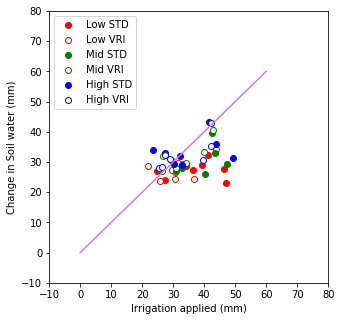

In [42]:
WUDays = ['2017-11-01', '2017-11-08',
 '2017-11-15', '2017-11-22',
 '2017-11-29', '2017-12-06',
 '2017-12-13', '2017-12-20',
 '2017-12-28']
WUTots = ObsPre.dropna(how='any')
CompData = WUTots.loc[WUTots.index.isin(WUDays),:].diff()
Fig = plt.figure(figsize=(5,5))
lineColors = ['r','r','g','g','b','b']
fillColors = ['r','w','g','w','b','w']
pos = 0
for z in Zones:
    for i in Irrigs:
        Obs = CompData.loc[:,('Obs',z,i)]
        Pre = CompData.loc[:,('Pred',z,i)]
        plt.plot(Obs,Pre,'o',
                 mec=lineColors[pos],mfc=fillColors[pos],label=z+' '+i)
        pos+=1
plt.ylim(-10,80)
plt.xlim(-10,80)
plt.plot([0,60],[0,60],'-')
plt.ylabel('Change in Soil water (mm)')
plt.xlabel('Irrigation applied (mm)')
plt.legend(loc=2,numpoints=1)     

### Agreement is pretty good but the Mid VRI treatment water use consistently goes backwards on the day of irrigation suggesting more water was showing up in the profile than what was recoreded as applied irrigation.

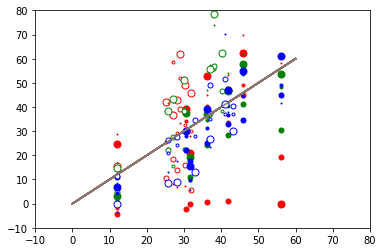

In [43]:
lineColors = ['r','r','g','g','b','b']
fillColors = ['r','w','g','w','b','w']
pos = 0
for z in Zones:
    for i in Irrigs:
        size = 1
        for r in [1,2,3,4]:
            SWincrease = DeltaSWCFrame.loc[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i,r)]*-1
            Applied = Irrigations.loc[Irrigations.index.isin(IrrigationsDaysIR),(z,i)]
            plt.plot(Applied,SWincrease,'o',mec=lineColors[pos],mfc=fillColors[pos],ms=size)
            plt.ylim(-10,80)
            plt.xlim(-10,80)
            plt.plot([0,60],[0,60],'-')
            size +=2
        pos+=1
        

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


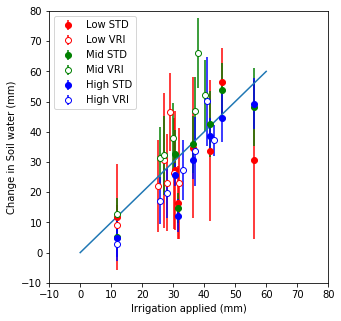

In [44]:
Fig = plt.figure(figsize=(5,5))
lineColors = ['r','r','g','g','b','b']
fillColors = ['r','w','g','w','b','w']
pos = 0
for z in Zones:
    for i in Irrigs:
        SWincrease = DeltaSWCFrame.loc[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i)].mean(axis=1)*-1
        SWincreaseSD = DeltaSWCFrame.loc[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i)].std(axis=1)
        Applied = Irrigations.loc[Irrigations.index.isin(IrrigationsDaysIR),(z,i)]
        plt.errorbar(Applied,SWincrease,SWincreaseSD,fmt='o',
                     mec=lineColors[pos],mfc=fillColors[pos],ecolor=lineColors[pos],label=z+' '+i)
        pos+=1
plt.ylim(-10,80)
plt.xlim(-10,80)
plt.plot([0,60],[0,60],'-')
plt.ylabel('Change in Soil water (mm)')
plt.xlabel('Irrigation applied (mm)')
plt.legend(loc=2,numpoints=1)        

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


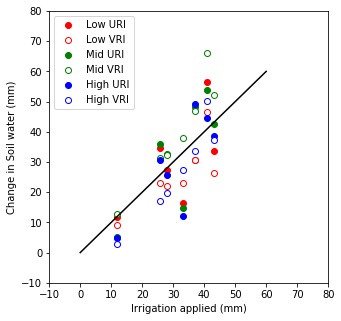

In [45]:
Fig = plt.figure(figsize=(5,5))
lineColors = ['r','r','g','g','b','b']
fillColors = ['r','w','g','w','b','w']
IrrLabs = ['URI', 'VRI','URI', 'VRI','URI', 'VRI']
pos = 0
for z in Zones:
    for i in Irrigs:
        SWincrease = DeltaSWCFrame.loc[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i)].mean(axis=1)*-1
        SWincreaseSD = DeltaSWCFrame.loc[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i)].std(axis=1)
        plt.plot(Applied,SWincrease,'o',
                     mec=lineColors[pos],mfc=fillColors[pos],label=z+' '+IrrLabs[pos])
        pos+=1
plt.ylim(-10,80)
plt.xlim(-10,80)
plt.plot([0,60],[0,60],'-',color='k')
plt.ylabel('Change in Soil water (mm)')
plt.xlabel('Irrigation applied (mm)')
plt.legend(loc=2,numpoints=1)  
Fig.savefig('K:\\CPDiary\\Data\\BaxtersMVI\\draft papers\\Submission versions\\resub\RevisedBaxtersIrrigPaper\\Figure7.jpg',dpi=400)

## Generally good agreement between the increase in soil water content and the amount of water applied but quite noisy.  The Mid VRI treatment is consistently over and all treatments on the biggest irrigation are consistently under.

## Make a dataframe with measured increase in soil water content and use that as or irrigation amount

In [46]:
IrrigationRetained = DeltaSWCFrame.loc[DeltaSWCFrame.index.isin(IrrigationsDaysNP)].copy()*-1+5
IrrigationRetained.index = IrrigationRetained.index - dt.timedelta(1)
IrrigationRetained = IrrigationRetained.loc[Irrigations.index]
IrrigationRetained.fillna(0,inplace=True)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


## Recalculate water balance using this irrigaiton

In [47]:
ColIndex = pd.MultiIndex.from_product([('Low','Mid','High'),('STD','VRI'),(1,2,3,4)],names=['Zone','Irrig','Rep'])
WaterUseNPMeasIrr = pd.DataFrame(index = Irrigations.index,
    columns = ColIndex)
WaterUseNPMeasIrr.loc[:,:]=0
DeltaSWCFrame = WaterUseNP.copy() 
for plot in WaterUseNPMeasIrr.columns:
    for P in WaterUseNPMeasIrr.index:
        if P.strftime('%Y-%m-%d') == '2017-10-04':
            PrevPSWC = SoilWaterData.loc[(plot)].loc[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = '2017-10-04'
        else:
            #print(P.strftime('%Y-%m-%d'))
            DeltaSWC = PrevPSWC - SoilWaterData.loc[(plot)].loc[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            #print(DeltaSWC)
            Irrigation = IrrigationRetained.loc[PrevMeasureDate,plot]
            #print(Irrigation)
            Rainfall = Irrigations.loc[P.strftime('%Y-%m-%d'),('Field','Rain')]
            #print(Rainfall)
            WU = DeltaSWC + Irrigation + Rainfall 
            #print(WU)
            WaterUseNPMeasIrr.loc[P.strftime('%Y-%m-%d'),plot] = WU
            PrevPSWC = SoilWaterData.loc[(plot)].loc[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = P.strftime('%Y-%m-%d')

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


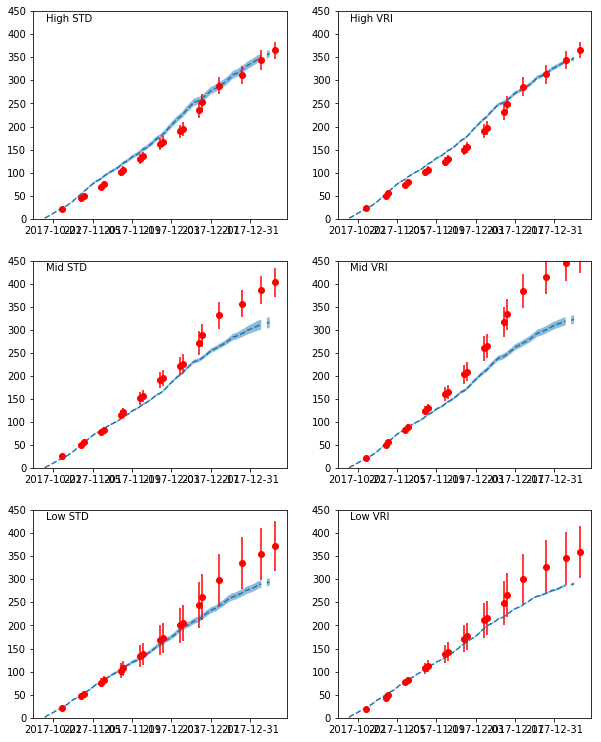

In [48]:
Fig = plt.figure(figsize=(10,13))
pos = 1
for z in ['High','Mid','Low']:
    for i in Irrigs:
        ax = Fig.add_subplot(3,2,pos)
        IRMean = E.loc[:,(z,i)].cumsum().mean(axis=1)
        IRSD = E.loc[:,(z,i)].cumsum().std(axis=1)/2
        IRUp = IRMean + IRSD
        IRLow = IRMean - IRSD
        plt.fill_between(E.index,IRUp,IRLow,alpha=0.5,lw=0)
        plt.plot(IRMean,'--')
        NPMean = WaterUseNPMeasIrr.loc['2017-10-20':,(z,i)].cumsum().mean(axis=1)
        NPSD = WaterUseNPMeasIrr.loc['2017-10-20':,(z,i)].cumsum().std(axis=1)/2
        NPUp = NPMean + NPSD
        NPLow = NPMean - NPSD
        plt.errorbar(WaterUseNPMeasIrr.loc['2017-10-20':,(z,i)].index,NPMean,NPSD,fmt='o',color='r')
        #plt.plot(NPMean,'o',color='r')
        plt.text(0.05,0.95,z+' ' +i,transform = ax.transAxes)
        pos += 1
        plt.ylim(0,450)